<a href="https://colab.research.google.com/github/anmolkohli18/pytorch-practice-examples/blob/main/02_pytorch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [3]:
print("First 5 X features:", X[:5])
print("First 5 y labels:", y[:5])

First 5 X features: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 y labels: [1 1 1 1 0]


In [4]:
import pandas as pd
circles = pd.DataFrame({
    "X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [5]:
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

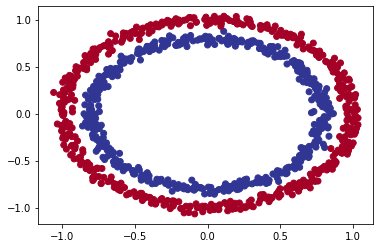

In [6]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
X_sample = X[0]
y_sample = y[0]
print("Values for one sample of X:", X_sample, "and the same for y:", y_sample)
print("Shapes for one sample of X:", X_sample.shape, "and the same for y:", y_sample.shape)

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


In [9]:
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]), tensor([1., 1., 1., 1., 0.]))

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [11]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [12]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)

  def forward(self, x):
    return self.layer_2(self.layer_1(x))

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [13]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
untrained_preds = model_0(X_test.to(device))
print("Length of predictions:", len(untrained_preds), "Shape:", untrained_preds.shape)
print("Length of test samples:", len(y_test), "Shape:", y_test.shape)
print("First 10 predictions:", untrained_preds[:10])
print("First 10 test labels:", y_test[:10])

Length of predictions: 200 Shape: torch.Size([200, 1])
Length of test samples: 200 Shape: torch.Size([200])
First 10 predictions: tensor([[ 0.5137],
        [ 0.4721],
        [ 0.3630],
        [ 0.5575],
        [-0.0495],
        [-0.0717],
        [ 0.1380],
        [ 0.0096],
        [ 0.3806],
        [ 0.4648]], grad_fn=<SliceBackward0>)
First 10 test labels: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [15]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [16]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [17]:
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.5137],
        [ 0.4721],
        [ 0.3630],
        [ 0.5575],
        [-0.0495]], grad_fn=<SliceBackward0>)

In [18]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.6257],
        [0.6159],
        [0.5898],
        [0.6359],
        [0.4876]], grad_fn=<SigmoidBackward0>)

In [19]:
y_preds = torch.round(y_pred_probs)

y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 1., 1., 0.], grad_fn=<SqueezeBackward0>)

In [20]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [21]:
torch.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_0.train()

  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  if epoch % 10 == 0:
    print("Epoch", epoch, "Loss: {:.4f}".format(loss.item()), "Accuracy: {:.4f}".format(acc), "Test loss: {:.4f}".format(test_loss.item()), "Test acc:", test_acc)

Epoch 0 Loss: 0.7067 Accuracy: 53.7500 Test loss: 0.7090 Test acc: 54.0
Epoch 10 Loss: 0.7013 Accuracy: 51.6250 Test loss: 0.7031 Test acc: 53.5
Epoch 20 Loss: 0.6989 Accuracy: 50.8750 Test loss: 0.7003 Test acc: 53.0
Epoch 30 Loss: 0.6977 Accuracy: 50.1250 Test loss: 0.6988 Test acc: 53.5
Epoch 40 Loss: 0.6969 Accuracy: 49.6250 Test loss: 0.6979 Test acc: 54.0
Epoch 50 Loss: 0.6963 Accuracy: 49.8750 Test loss: 0.6973 Test acc: 53.5
Epoch 60 Loss: 0.6959 Accuracy: 49.8750 Test loss: 0.6969 Test acc: 53.5
Epoch 70 Loss: 0.6956 Accuracy: 49.6250 Test loss: 0.6965 Test acc: 54.0
Epoch 80 Loss: 0.6953 Accuracy: 49.5000 Test loss: 0.6962 Test acc: 53.5
Epoch 90 Loss: 0.6950 Accuracy: 49.3750 Test loss: 0.6960 Test acc: 52.0


In [22]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

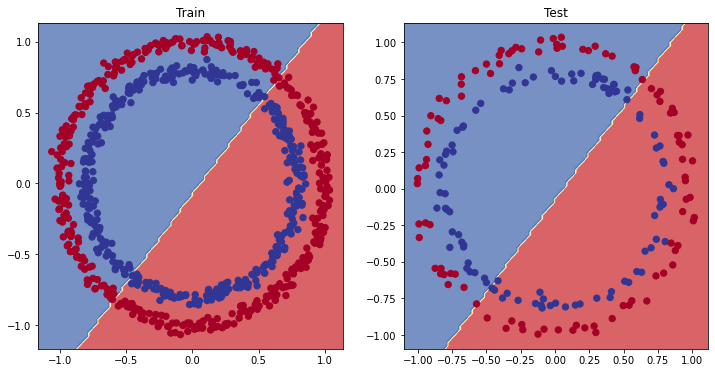

In [23]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [24]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [25]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [28]:
torch.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  if epoch % 100 == 0:
    print("Epoch:", epoch, "Loss: {:.4f}".format(loss), "Accuracy: {:.4f}".format(acc))
    print("Test loss: {:.4f}".format(test_loss), "Test accuracy: {:.4f}".format(test_acc))

Epoch: 0 Loss: 0.6939 Accuracy: 50.5000
Test loss: 0.6926 Test accuracy: 50.5000
Epoch: 100 Loss: 0.6930 Accuracy: 50.5000
Test loss: 0.6938 Test accuracy: 47.5000
Epoch: 200 Loss: 0.6930 Accuracy: 51.1250
Test loss: 0.6944 Test accuracy: 46.0000
Epoch: 300 Loss: 0.6930 Accuracy: 51.3750
Test loss: 0.6946 Test accuracy: 45.0000
Epoch: 400 Loss: 0.6930 Accuracy: 51.1250
Test loss: 0.6946 Test accuracy: 46.0000
Epoch: 500 Loss: 0.6930 Accuracy: 51.0000
Test loss: 0.6947 Test accuracy: 46.0000
Epoch: 600 Loss: 0.6930 Accuracy: 51.0000
Test loss: 0.6947 Test accuracy: 46.0000
Epoch: 700 Loss: 0.6930 Accuracy: 51.0000
Test loss: 0.6947 Test accuracy: 46.0000
Epoch: 800 Loss: 0.6930 Accuracy: 51.0000
Test loss: 0.6947 Test accuracy: 46.0000
Epoch: 900 Loss: 0.6930 Accuracy: 51.0000
Test loss: 0.6947 Test accuracy: 46.0000


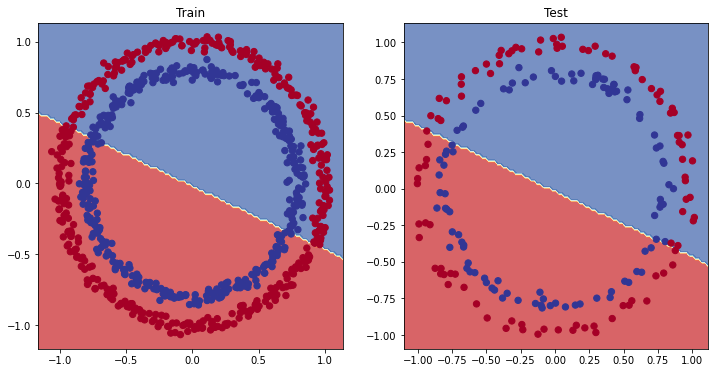

In [30]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [31]:
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]), tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [33]:
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

print(len(X_train_regression),
      len(y_train_regression),
      len(X_test_regression),
      len(y_test_regression))

80 80 20 20


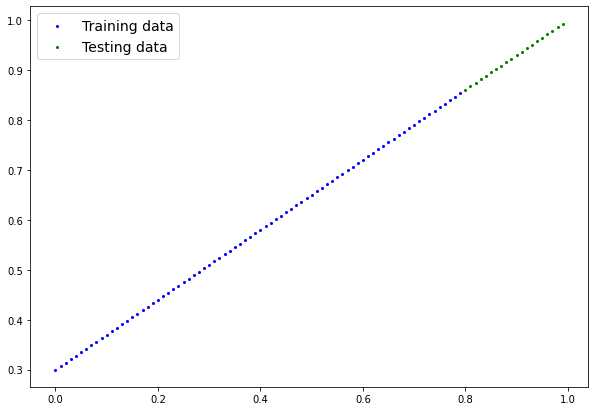

In [34]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

In [35]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [36]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [37]:
torch.manual_seed(42)

epochs = 1000

X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
  model_2.train()

  y_pred = model_2(X_train_regression)

  loss = loss_fn(y_pred, y_train_regression)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)

  if epoch % 100 == 0:
    print("Epoch:", epoch, "Train loss: {:.4f}".format(loss), "Test loss: {:.4f}".format(test_loss))

Epoch: 0 Train loss: 0.7599 Test loss: 0.5414
Epoch: 100 Train loss: 0.0931 Test loss: 0.0290
Epoch: 200 Train loss: 0.0738 Test loss: 0.0285
Epoch: 300 Train loss: 0.0675 Test loss: 0.0062
Epoch: 400 Train loss: 0.0611 Test loss: 0.0200
Epoch: 500 Train loss: 0.0570 Test loss: 0.0106
Epoch: 600 Train loss: 0.0486 Test loss: 0.0133
Epoch: 700 Train loss: 0.0611 Test loss: 0.0213
Epoch: 800 Train loss: 0.0560 Test loss: 0.0143
Epoch: 900 Train loss: 0.0557 Test loss: 0.0060


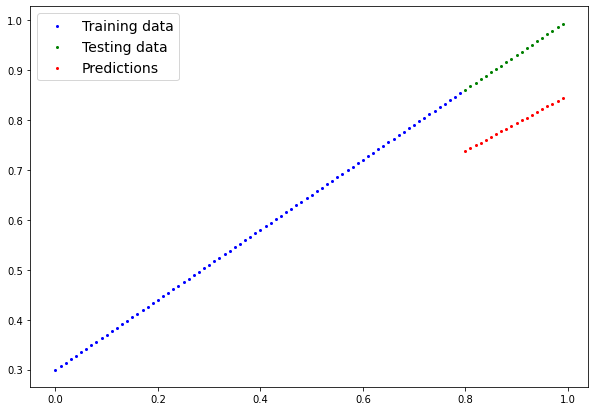

In [38]:
model_2.eval()

with torch.inference_mode():
  y_preds = model_2(X_test_regression)

plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu())

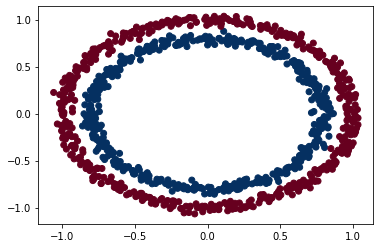

In [39]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000
X, y = make_circles(n_samples=1000,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu)

In [40]:
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]), tensor([1., 0., 0., 0., 1.]))

In [52]:
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [53]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [54]:
torch.manual_seed(42)
epochs = 1500

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  if epoch % 150 == 0:
    print("Epoch:", epoch, "Loss: {:.4f}".format(loss), "Accuracy:", acc, "Test loss: {:.4f}".format(test_loss), "Test accuracy:", test_acc)

Epoch: 0 Loss: 0.6929 Accuracy: 50.0 Test loss: 0.6932 Test accuracy: 50.0
Epoch: 150 Loss: 0.6905 Accuracy: 52.87500000000001 Test loss: 0.6903 Test accuracy: 55.00000000000001
Epoch: 300 Loss: 0.6879 Accuracy: 53.0 Test loss: 0.6872 Test accuracy: 56.00000000000001
Epoch: 450 Loss: 0.6833 Accuracy: 52.75 Test loss: 0.6820 Test accuracy: 56.00000000000001
Epoch: 600 Loss: 0.6751 Accuracy: 54.50000000000001 Test loss: 0.6729 Test accuracy: 56.00000000000001
Epoch: 750 Loss: 0.6599 Accuracy: 61.12499999999999 Test loss: 0.6560 Test accuracy: 63.0
Epoch: 900 Loss: 0.6236 Accuracy: 74.0 Test loss: 0.6215 Test accuracy: 79.0
Epoch: 1050 Loss: 0.5285 Accuracy: 91.375 Test loss: 0.5395 Test accuracy: 89.5
Epoch: 1200 Loss: 0.3706 Accuracy: 97.75 Test loss: 0.4059 Test accuracy: 92.0
Epoch: 1350 Loss: 0.2081 Accuracy: 99.5 Test loss: 0.2581 Test accuracy: 97.5


In [55]:
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_preds[:5], y[:5]

(tensor([1., 0., 1., 0., 1.]), tensor([1., 1., 1., 1., 0.]))

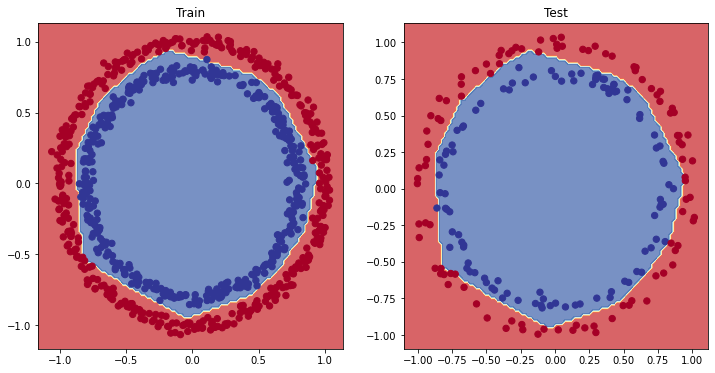

In [57]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

In [58]:
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

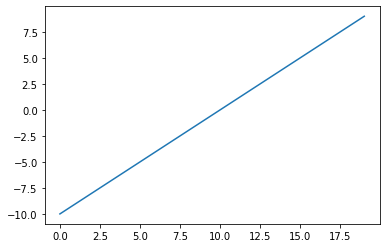

In [59]:
plt.plot(A)

In [60]:
def relu(x):
  return torch.maximum(torch.tensor(0), x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

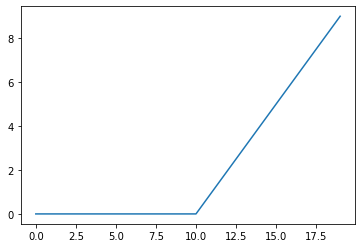

In [61]:
plt.plot(relu(A))

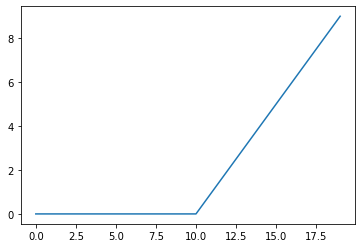

In [63]:
relu = nn.ReLU()

plt.plot(relu(A))

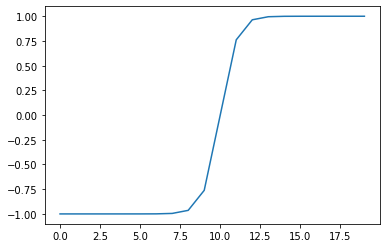

In [135]:
plt.plot(nn.Tanh()(A))

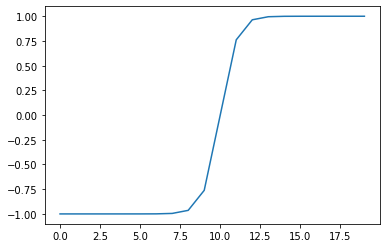

In [136]:
def tanh(x):
  return (torch.exp(x)  - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))

plt.plot(tanh(A))

In [64]:
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

  sigmoid(A)

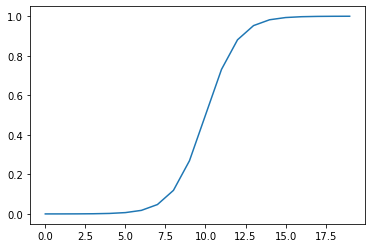

In [65]:
plt.plot(sigmoid(A))

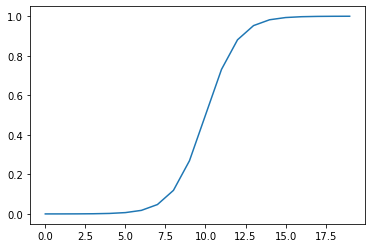

In [67]:
plt.plot(torch.sigmoid(A))

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


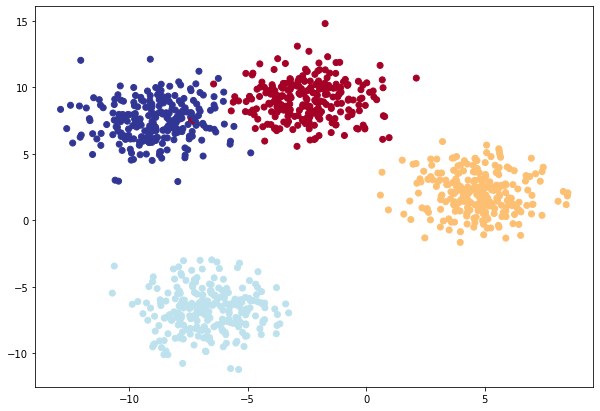

In [85]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000, n_features=NUM_FEATURES,
                            centers=NUM_CLASSES, cluster_std=1.5,
                            random_state=RANDOM_SEED)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED
)

plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [86]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [87]:
from torch import nn

class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [88]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)

In [89]:
model_4(X_blob_train.to(device))[:5]

tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        [ 1.9576,  0.3125,  2.2244,  1.1324],
        [ 0.5458, -1.2381,  0.4441,  1.1804]], grad_fn=<SliceBackward0>)

In [90]:
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

In [91]:
y_logits = model_4(X_blob_test.to(device))

y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]], grad_fn=<SliceBackward0>)
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]], grad_fn=<SliceBackward0>)


In [92]:
torch.sum(y_pred_probs, dim=1)[:5]

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<SliceBackward0>)

In [93]:
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1872, 0.2918, 0.1495, 0.3715], grad_fn=<SelectBackward0>)
tensor(3)


In [95]:
torch.manual_seed(42)

epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
  model_4.train()

  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_pred)

  if epoch % 10 == 0:
    print("Epoch:", epoch, "Loss:", loss, "accuracy:", acc, "test loss:", test_loss, "test accuracy:", test_acc)

Epoch: 0 Loss: tensor(0.5752, grad_fn=<NllLossBackward0>) accuracy: 95.375 test loss: tensor(0.4267) test accuracy: 97.5
Epoch: 10 Loss: tensor(0.1329, grad_fn=<NllLossBackward0>) accuracy: 99.125 test loss: tensor(0.1205) test accuracy: 99.0
Epoch: 20 Loss: tensor(0.0775, grad_fn=<NllLossBackward0>) accuracy: 99.125 test loss: tensor(0.0692) test accuracy: 99.5
Epoch: 30 Loss: tensor(0.0579, grad_fn=<NllLossBackward0>) accuracy: 99.125 test loss: tensor(0.0500) test accuracy: 99.5
Epoch: 40 Loss: tensor(0.0482, grad_fn=<NllLossBackward0>) accuracy: 99.0 test loss: tensor(0.0402) test accuracy: 99.5
Epoch: 50 Loss: tensor(0.0425, grad_fn=<NllLossBackward0>) accuracy: 99.0 test loss: tensor(0.0344) test accuracy: 99.5
Epoch: 60 Loss: tensor(0.0388, grad_fn=<NllLossBackward0>) accuracy: 99.0 test loss: tensor(0.0305) test accuracy: 99.5
Epoch: 70 Loss: tensor(0.0362, grad_fn=<NllLossBackward0>) accuracy: 99.0 test loss: tensor(0.0277) test accuracy: 99.5
Epoch: 80 Loss: tensor(0.0343, gr

In [96]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

y_logits[:5]

tensor([[  4.3551,  10.3920, -14.9378,  -9.7940],
        [  5.0249, -12.0799,   3.3984,  10.6999],
        [ -5.6140, -13.3927,  21.0484,  12.8085],
        [  1.8479,   7.5879,  -8.6272,  -7.0156],
        [  8.0997,   3.3034, -14.6397,  -3.6309]])

In [98]:
y_pred_probs = torch.softmax(y_logits, dim=1)

y_preds = y_pred_probs.argmax(dim=1)

print("Predictions:", y_preds[:5], "Labels:", y_blob_test[:5])
print("Test accuracy:", accuracy_fn(y_true=y_blob_test, y_pred=y_preds))

Predictions: tensor([1, 3, 2, 1, 0]) Labels: tensor([1, 3, 2, 1, 0])
Test accuracy: 99.5


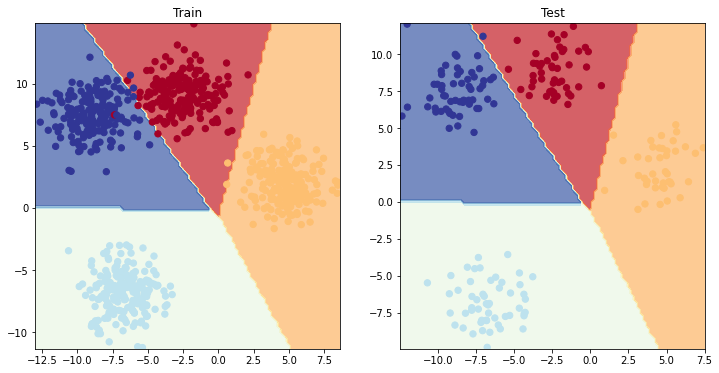

In [99]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

In [100]:
try:
  from torchmetrics import Accuracy
except:
  !pip install torchmetrics
  from torchmetrics import Accuracy

torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

torchmetrics_accuracy(y_preds, y_blob_test)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.6/518.6 KB 18.9 MB/s eta 0:00:00


tensor(0.9950)

In [101]:
from sklearn.datasets import make_moons

In [102]:
X_moon, y_moon = make_moons(n_samples=1000,
           noise=0.03,
           random_state=42)

X_moon[:5], y_moon[:5]

(array([[-0.00933187,  0.39098105],
        [ 0.95457387, -0.47375583],
        [ 0.9185256 , -0.42519648],
        [ 0.41276802, -0.37638459],
        [-0.84532016,  0.52879908]]), array([1, 1, 1, 1, 0]))

In [115]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X_moon).type(torch.float)
y = torch.from_numpy(y_moon).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(len(X_train), len(X_test), len(y_train), len(y_test))

800 200 800 200


In [128]:
class MoonModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=2, out_features=10),
        nn.ReLU(),
        nn.Linear(in_features=10, out_features=10),
        nn.ReLU(),
        nn.Linear(in_features=10, out_features=1),
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

model_5 = MoonModel().to(device)
model_5

MoonModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [129]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_5.parameters(), lr=0.1)

In [130]:
torch.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_5.train()

  y_logits = model_5(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))
  
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_preds)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_5.eval()
  with torch.inference_mode():
    test_logits = model_5(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)

  if epoch % 100 == 0:
    print("Epoch:", epoch, "loss:", loss, "acc:", acc, "test loss:", test_loss, "test acc:", test_acc)

Epoch: 0 loss: tensor(0.6954, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) acc: 37.75 test loss: tensor(0.6946) test acc: 49.5
Epoch: 100 loss: tensor(0.3864, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) acc: 81.875 test loss: tensor(0.4020) test acc: 77.0
Epoch: 200 loss: tensor(0.2366, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) acc: 88.625 test loss: tensor(0.2376) test acc: 90.0
Epoch: 300 loss: tensor(0.1908, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) acc: 91.375 test loss: tensor(0.1853) test acc: 92.5
Epoch: 400 loss: tensor(0.1515, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) acc: 93.75 test loss: tensor(0.1445) test acc: 94.0
Epoch: 500 loss: tensor(0.1069, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) acc: 95.625 test loss: tensor(0.0997) test acc: 97.5
Epoch: 600 loss: tensor(0.0690, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) acc: 98.5 test loss: tensor(0.0630) test acc: 99.0
Epoch: 700 loss: tensor(0.0442, grad_fn=<BinaryCrossEntropyWithLogit

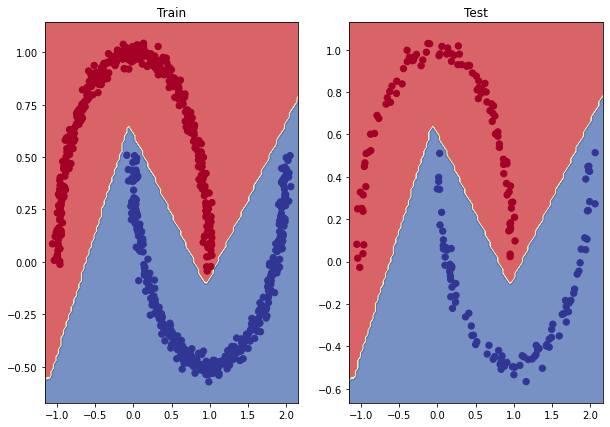

In [131]:
plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_5, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_5, X_test, y_test)